# Retrofitting to the structure of FrameNet

In [1]:
__author__ = 'Ben Lengerich'

__Question__: Does FrameNet benefit from added flexibility for retrofitting?

In [3]:
from gensim.models import KeyedVectors
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import framenet as fn
import numpy as np
import scipy
from sklearn.decomposition import IncrementalPCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
import time

import sys
sys.path.append("../../")
from utils import *
from retrofit_linear import retrofit_linear
from retrofit_identity import retrofit_identity
from retrofit_neural import retrofit_neural

## Load Pre-trained Distributional Embeddings

In [4]:
word2vec_filename='../../GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(word2vec_filename, binary=True)

## Extract FrameNet Distributional Representations

In [5]:
t = time.time()

# Nodes are the union of lexical units and frames
nodes = []
node_types = [] # For evaluation, need to remember what type nodes are
node_ids = []
row_ids = {}
X = []

n_lu_in_w2v = 0
n_fr_in_w2v = 0
for lu in fn.lus():
    nodes.append(lu)
    ID = "lu_{}".format(lu.ID)
    node_ids.append(ID)
    row_ids[ID] = len(X)
    node_types.append("lu")
    lexeme = lu.name.split('.')[0]
    try:
        X.append(model[lexeme])
        n_lu_in_w2v += 1
    except KeyError:
        X.append(np.zeros((300)))
n_lu = len(X)
print("Added {} nodes of Lexical Units, {} had representations in W2v".format(n_lu, n_lu_in_w2v))    

for frame in fn.frames():
    nodes.append(frame)
    ID = "fr_{}".format(frame.ID)
    row_ids[ID] = len(X)
    node_ids.append(ID)
    node_types.append("frame")
    try:
        X.append(model[frame.name])
        n_fr_in_w2v += 1
    except KeyError:
        X.append(np.zeros((300)))
print("Added {} nodes of Frames, {} had representations in W2v".format(len(X) - n_lu, n_fr_in_w2v))
print("Took {:.2f} seconds".format(time.time() - t))

Added 13572 nodes of Lexical Units, 12167 had representations in W2v
Added 1221 nodes of Frames, 464 had representations in W2v
Took 4.76 seconds


## Extract Edges from FrameNet

In [17]:
t = time.time()
in_edges = {"lu": {}}
out_edges = {"lu": {}}
relation_types = []
neighbors = {}
n_lurs = 0
n_frs = 0
for i in range(n_lu, len(X)): # iterate over frames
    frame = nodes[i]
    # Add Lexical Unit Relations
    for lu in frame.lexUnit.values():
        lu_row = row_ids["lu_{}".format(lu.ID)]
        try:
            out_edges["lu"][i].append(lu_row)
        except KeyError:
            out_edges["lu"][i] = [lu_row]
        try:
            in_edges["lu"][lu_row].append(i)
        except KeyError:
            in_edges["lu"][lu_row] = [i]
    n_lurs += 1
    
    # Add Frame Relations
    for fr in frame.frameRelations:
        fr_type = fr.__str__().split('-')[2].strip() # super hacky way of getting the relation type
        fr_parent = row_ids["fr_{}".format(fr.superFrame.ID)]
        fr_child = row_ids["fr_{}".format(fr.subFrame.ID)]
        try:
            out_edges[fr_type][fr_parent].append(fr_child)
        except KeyError:
            try:
                out_edges[fr_type][fr_parent] = [fr_child]
            except KeyError:
                out_edges[fr_type] = {fr_parent: [fr_child]}
        try:
            in_edges[fr_type][fr_child].append(fr_parent)
        except KeyError:
            try:
                in_edges[fr_type][fr_child] = [fr_parent]
            except KeyError:
                in_edges[fr_type] = {fr_child: [fr_parent]}
        n_frs += 1

print("Added {} edges between frames, {} edges from frames to LUs.".format(n_frs, n_lurs))
out_edges_filtered = {}
in_edges_filtered = {}
min_threshold = 10
for edge_type, edge_dict in out_edges.items():
    n_edges = 0
    for head, tails in edge_dict.items():
        n_edges += len(tails)
    if n_edges > min_threshold: #and edge_type in allowed_edge_types:
        out_edges_filtered[edge_type] = edge_dict
        print("{:d} Out Edges of Type: {}".format(n_edges, edge_type))
out_edges = out_edges_filtered
    
for edge_type, edge_dict in in_edges.items():
    n_edges = 0
    for head, tails in edge_dict.items():
        n_edges += len(tails)
    if n_edges > min_threshold:
        in_edges_filtered[edge_type] = edge_dict
        print("{:d} In Edges of Type: {}".format(n_edges, edge_type))
in_edges = in_edges_filtered
    
for rel_name in in_edges.keys():
    for i in range(len(X)):
        try:
            in_edges[rel_name][i]
        except KeyError:
            in_edges[rel_name][i] = []
            
for rel_name in out_edges.keys():
    for i in range(len(X)):
        try:
            out_edges[rel_name][i]
        except KeyError:
            out_edges[rel_name][i] = []
    
print("Took {:.2f} seconds.".format(time.time() - t))

Added 4140 edges between frames, 1221 edges from frames to LUs.
20 Out Edges of Type: 
1110 Out Edges of Type: Using
1562 Out Edges of Type: Inheritance
13572 Out Edges of Type: lu
172 Out Edges of Type: See_also
178 Out Edges of Type: Precedes
38 Out Edges of Type: Inchoative_of
428 Out Edges of Type: ReFraming_Mapping
242 Out Edges of Type: Perspective_on
120 Out Edges of Type: Causative_of
262 Out Edges of Type: Subframe
20 In Edges of Type: 
1110 In Edges of Type: Using
1562 In Edges of Type: Inheritance
13572 In Edges of Type: lu
172 In Edges of Type: See_also
178 In Edges of Type: Precedes
38 In Edges of Type: Inchoative_of
428 In Edges of Type: ReFraming_Mapping
242 In Edges of Type: Perspective_on
120 In Edges of Type: Causative_of
262 In Edges of Type: Subframe
Took 0.24 seconds.


In [18]:
# Save everything
save_obj(X, 'X')
save_obj(in_edges, 'in_edges')
save_obj(out_edges, 'out_edges')

In [19]:
# Load everything here. We can restart everything below can be restarted from this cell (and the imports above).
X_w2v = load_obj('X')
X_w2v = normalize(X_w2v, norm='l2')
out_edges = load_obj('out_edges')
in_edges = load_obj('in_edges')

## Retrofit

In [20]:
best_dim_raw = 100
best_dim_ide = 50
best_dim_lin = 50
best_dim_neu = 15
n_iters = 3
pca = IncrementalPCA(n_components=best_dim_raw)
X_w2v_reduced = pca.fit_transform(X_w2v)
pca = IncrementalPCA(n_components=best_dim_ide)
X_w2v_reduced_ide = pca.fit_transform(X_w2v)
pca = IncrementalPCA(n_components=best_dim_lin)
X_w2v_reduced_lin = pca.fit_transform(X_w2v)
pca = IncrementalPCA(n_components=best_dim_neu)
X_w2v_reduced_neu = pca.fit_transform(X_w2v)

# For each relation, we retrofit without that relation.
# Then we test the performance of a random forest to predict that relation.
all_rels = set(in_edges.keys())
for rel in all_rels:
    if rel is '' or rel=='lu':
        continue
    print("Leaving out Relations of Type: '{}'".format(rel))
    rels_to_fit = all_rels - set(rel)
    in_edges_to_fit = {r: in_edges[r] for r in rels_to_fit}
    out_edges_to_fit = {r: out_edges[r] for r in rels_to_fit}
    
    scores = {
        'Dummy'    : [],
        'Raw'      : [],
        'Identity' : [],
        'Linear'   : [],
        'Neural'   : []
    }
    
    for iteration in range(1, n_iters+1):
        print("Iteration {} of {}".format(iteration, n_iters))
        p_train = 0.7
        train_indices, test_indices, neg_train_indices, neg_test_indices = get_train_test_indices(
            in_edges_to_fit[rel], p_train)
        Y_train = np.ones(len(train_indices))
        Y_train = np.concatenate((Y_train, np.zeros((len(neg_train_indices), ))))
        Y_test = np.ones(len(test_indices))
        Y_test = np.concatenate((Y_test, np.zeros((len(neg_test_indices), ))))
        train_indices.extend(neg_train_indices)
        test_indices.extend(neg_test_indices)
        make_train_test = lambda rep: (np.array([np.hstack((rep[i], rep[j])) for (i,j) in train_indices]),
                                       np.array([np.hstack((rep[i], rep[j])) for (i,j) in test_indices]))

        # Retrofit
        print("-"*20)
        print("Retrofitting Identity...")
        t = time.time()
        X_w2v_ide = retrofit_identity(
            X_w2v_reduced_ide, in_edges_to_fit, n_iter=20, verbose=True)
        print("Identity retrofitting took {:.2f} seconds.".format(time.time() - t))
        print("-"*20)
        print("Retrofitting Linear...")
        t = time.time()
        X_w2v_lin, A, B = retrofit_linear(
            X_w2v_reduced_lin, in_edges_to_fit, out_edges_to_fit, orthogonal=False,
            n_iter=20, lam=1e-3, lr=0.1, lr_decay=0.95, verbose=True)
        print("Linear retrofitting took {:.2f} seconds.".format(time.time() - t))
        print("-"*20)
        print("Retrofitting Neural...")
        t = time.time()
        X_w2v_neu, A, U, B = retrofit_neural(
            X_w2v_reduced_neu, in_edges_to_fit, out_edges_to_fit, k=15, tol=1e-5,
            n_iter=200, lam=1e-3, lr=0.01, lr_decay=0.99, batch_size=256, patience=5, verbose=20)
        print("Neural retrofitting took {:.2f} seconds.".format(time.time() - t))

        # Prepare train/test split
        (X_train_w2v,     X_test_w2v)     = make_train_test(X_w2v_reduced)
        (X_train_w2v_ide, X_test_w2v_ide) = make_train_test(X_w2v_ide)
        (X_train_w2v_lin, X_test_w2v_lin) = make_train_test(X_w2v_lin)
        (X_train_w2v_neu, X_test_w2v_neu) = make_train_test(X_w2v_neu)
    
        # Sanity check (should always be 50.0% accuracy)
        dummy = DummyClassifier(strategy='most_frequent')
        dummy.fit(X_train_w2v, Y_train)
        scores['Dummy'].append(dummy.score(X_test_w2v, Y_test))
        
        # Train Random Forest, calculate accuracies        
        rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
        rf.fit(X_train_w2v, Y_train)
        scores['Raw'].append(rf.score(X_test_w2v, Y_test))
        rf.fit(X_train_w2v_ide, Y_train)
        scores['Identity'].append(rf.score(X_test_w2v_ide, Y_test))
        rf.fit(X_train_w2v_lin, Y_train)
        scores['Linear'].append(rf.score(X_test_w2v_lin, Y_test))
        rf.fit(X_train_w2v_neu, Y_train)
        scores['Neural'].append(rf.score(X_test_w2v_neu, Y_test))
    
    print("="*60 + "\nAccuracies for Edges of Type: '{}' (# training: {}, # testing: {})".format(
          rel, len(Y_train), len(Y_test)))    
    print("Dummy:                     {:.4f}+-{:.4f}".format(np.mean(scores['Dummy']), np.std(scores['Dummy'])))
    print("Distributional RF:         {:.4f}+-{:.4f}".format(np.mean(scores['Raw']), np.std(scores['Raw'])))
    print("Identity Retrofitting RF:  {:.4f}+-{:.4f}".format(np.mean(scores['Identity']), np.std(scores['Identity'])))
    print("Linear Retrofitting RF:    {:.4f}+-{:.4f}".format(np.mean(scores['Linear']), np.std(scores['Linear'])))
    print("Neural Retrofiting RF:     {:.4f}+-{:.4f}".format(np.mean(scores['Neural']), np.std(scores['Neural'])))
    print("="*80)

Leaving out Relations of Type: 'Using'
--------------------
Retrofitting Identity...
Converged at iteration 6
Identity retrofitting took 1.41 seconds.
--------------------
Retrofitting Linear...
Matrix is singular and may not have a square root.
Iteration 1 of 20	Changes: 0.392	Loss: 9436.183
Loss reached local minimum at iteration 1
Linear retrofitting took 15.12 seconds.
--------------------
Retrofitting Neural...
Iteration 20 of 200	Changes: 0.00209	Loss: 0.547	Patience: 0
Loss reached local minimum (and patience expired) at iteration 20
Neural retrofitting took 7.74 seconds.
--------------------
Retrofitting Identity...
Converged at iteration 6
Identity retrofitting took 1.42 seconds.
--------------------
Retrofitting Linear...
Matrix is singular and may not have a square root.
Iteration 1 of 20	Changes: 0.392	Loss: 9436.336
Loss reached local minimum at iteration 1
Linear retrofitting took 15.07 seconds.
--------------------
Retrofitting Neural...
Loss reached local minimum (and p

Loss reached local minimum at iteration 1
Linear retrofitting took 15.09 seconds.
--------------------
Retrofitting Neural...
Loss reached local minimum (and patience expired) at iteration 15
Neural retrofitting took 5.56 seconds.
--------------------
Retrofitting Identity...
Converged at iteration 6
Identity retrofitting took 1.59 seconds.
--------------------
Retrofitting Linear...
Matrix is singular and may not have a square root.
Iteration 1 of 20	Changes: 0.392	Loss: 9436.979
Loss reached local minimum at iteration 1
Linear retrofitting took 15.65 seconds.
--------------------
Retrofitting Neural...
Iteration 20 of 200	Changes: 0.00626	Loss: 0.357	Patience: 1
Loss reached local minimum (and patience expired) at iteration 23
Neural retrofitting took 8.28 seconds.
--------------------
Retrofitting Identity...
Converged at iteration 6
Identity retrofitting took 1.43 seconds.
--------------------
Retrofitting Linear...
Matrix is singular and may not have a square root.
Iteration 1 of 

Matrix is singular and may not have a square root.
Iteration 1 of 20	Changes: 0.392	Loss: 9436.435
Loss reached local minimum at iteration 1
Linear retrofitting took 14.88 seconds.
--------------------
Retrofitting Neural...
Iteration 20 of 200	Changes: 0.01384	Loss: 0.425	Patience: 1
Loss reached local minimum (and patience expired) at iteration 24
Neural retrofitting took 9.29 seconds.
--------------------
Retrofitting Identity...
Converged at iteration 6
Identity retrofitting took 1.38 seconds.
--------------------
Retrofitting Linear...
Matrix is singular and may not have a square root.
Iteration 1 of 20	Changes: 0.392	Loss: 9436.979
Loss reached local minimum at iteration 1
Linear retrofitting took 15.68 seconds.
--------------------
Retrofitting Neural...
Loss reached local minimum (and patience expired) at iteration 17
Neural retrofitting took 6.62 seconds.
----------------------------------------
Accuracies for Edges of Type: 'Subframe' (# training: 340, # testing: 184)
Dummy: 

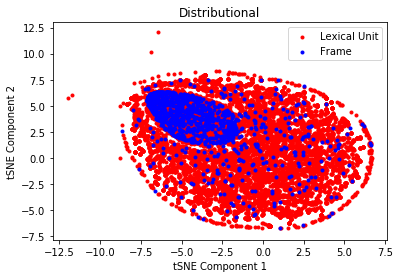

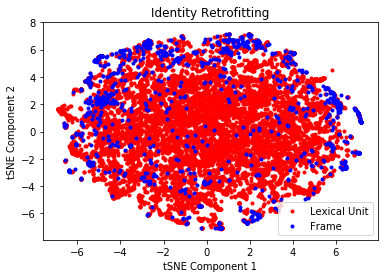

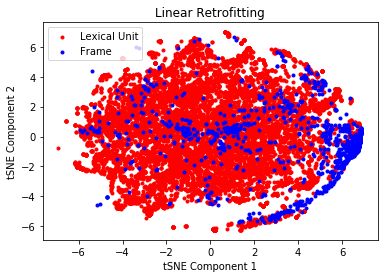

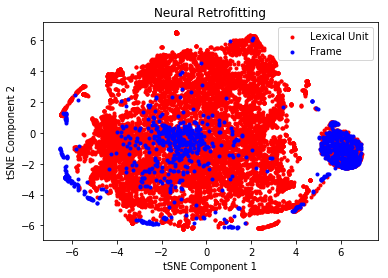

In [21]:
%matplotlib inline
plot = lambda x, title: plot_embeddings(x, title, ['Lexical Unit', 'Frame'], [13572, 1221], n_iter=200)

plot(X_w2v,     'Distributional')
plot(X_w2v_ide, 'Identity Retrofitting')
plot(X_w2v_lin, 'Linear Retrofitting')
plot(X_w2v_neu, 'Neural Retrofitting')